In [2]:
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
import math


# NN
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2, ResNet101V2
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import random
# NORMAL
image_folder_normal = 'chest_xray/chest_xray/train/NORMAL/'

# List all image files in the folder
image_files_normal = sorted([f for f in os.listdir(image_folder_normal) if f.endswith(('jpeg'))])

# Initialize lists to store file names and image data
vec_normal = []
image_arrays_normal = []

# Loop through each image file and process
for image_file in image_files_normal:
    # Load image
    img = Image.open(os.path.join(image_folder_normal, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')

    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_normal.append(img_array)
    vec_normal.append(image_file)

# Create a pandas DataFrame
df_normal = pd.DataFrame({
    'file_name': [image_folder_normal + item for item in vec_normal],
    'image_array': image_arrays_normal,
    'label': 'NORMAL'
})

# BACTERIA

image_folder_pneumonia = 'chest_xray/chest_xray/train/PNEUMONIA/'

# List all image files in the folder
image_files_bacteria = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'bacteria' in f.lower()])

# Initialize lists to store file names and image data
vec_bacteria = []
image_arrays_bacteria = []

# Loop through each image file and process
for image_file in image_files_bacteria:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_bacteria.append(img_array)

    # Append file name and image data to lists
    vec_bacteria.append(image_file)

# Create a pandas DataFrame
df_bacteria = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in vec_bacteria],
    'image_array': image_arrays_bacteria,
    'label': 'BACTERIA'
})

# VIRUS

image_files_virus = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'virus' in f.lower()])

# Initialize lists to store file names and image data
file_names_virus = []
image_arrays_virus = []

# Loop through each image file and process
for image_file in image_files_virus:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_virus.append(img_array)

    # Append file name and image data to lists
    file_names_virus.append(image_file)

# Create a pandas DataFrame
df_virus = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in file_names_virus],
    'image_array': image_arrays_virus,
    'label': 'VIRUS'
})

df_combined = pd.DataFrame({
    'file_name': df_normal['file_name'].tolist() + df_bacteria['file_name'].tolist() + df_virus['file_name'].tolist(),
    'image_array': df_normal['image_array'].tolist() + df_bacteria['image_array'].tolist() + df_virus['image_array'].tolist(),
    'label': df_normal['label'].tolist() + df_bacteria['label'].tolist() + df_virus['label'].tolist()
})
# Data 1
def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/10)*(x-123))

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0

bright_matrix = df_combined['image_array']
X = brightness_f(bright_matrix)
P, W, Y1, Y0 = assign(X)
df_combined['P'] = P
df_combined['W'] = W
df_combined['Y1'] = Y1
df_combined['Y0'] = Y0
df_combined['Y'] = df_combined['W'] * df_combined['Y1'] + (1 - df_combined['W']) * df_combined['Y0']
## NTK



In [3]:
# === Set seed ===
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(0)

# === Utility Functions ===
def brightness_f(x):
    return np.array([np.mean(i) for i in x])

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

def propensity_score(x):
    return inv_logit((1/15)*(x - 123))

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0

# === Data ===
L = df_combined['label'].values
X_brightness = brightness_f(df_combined['image_array'])
P, W, Y1, Y0 = assign(X_brightness)

df_combined['W'] = W
df_combined['Y1'] = Y1
df_combined['Y0'] = Y0
df_combined['Y'] = W * Y1 + (1 - W) * Y0

X_images = np.array([np.array(x) for x in df_combined['image_array']]).reshape(-1, 224, 224, 1)
Y_full = df_combined['Y'].values

train_idx, grad_idx = train_test_split(np.arange(len(X_images)), test_size=0.5, random_state=0)
X_train, y_train = X_images[train_idx], Y_full[train_idx]
X_grad = X_images[grad_idx]
W_grad, Y1_grad, Y0_grad = W[grad_idx], Y1[grad_idx], Y0[grad_idx]
y_grad = Y_full[grad_idx]


In [4]:
from tensorflow.keras.optimizers import Adam

def modeling():
    image_input = Input(shape=(224, 224, 1))
    x = Conv2D(16, (3, 3), activation='relu')(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs=image_input, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# === Train control and treated models ===
X_control = X_train[W[train_idx] == 0]
y_control = y_train[W[train_idx] == 0]
X_treated = X_train[W[train_idx] == 1]
y_treated = y_train[W[train_idx] == 1]

model_control = modeling()
model_control.fit(X_control, y_control, epochs=5, batch_size=16, validation_split=0.2)

model_treated = modeling()
model_treated.fit(X_treated, y_treated, epochs=5, batch_size=16, validation_split=0.2)

model_full = modeling()
model_full.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

# === Predictions ===

y_pred = model_full.predict(X_grad).flatten()
y_pred_control = model_control.predict(X_grad).flatten()
y_pred_treated = model_treated.predict(X_grad).flatten()

# === Gradients ===
def grad(i, model):
    img = tf.convert_to_tensor(X_grad[i:i+1], dtype=tf.float32)
    with tf.GradientTape() as tape:
        pred = model(img, training=True)
    grads = tape.gradient(pred, model.trainable_variables)
    return np.concatenate([g.numpy().flatten() for g in grads if g is not None])

f0_grads = [grad(i, model_control) for i in tqdm(range(len(X_grad)))]
f1_grads = [grad(i, model_treated) for i in tqdm(range(len(X_grad)))]



2025-04-05 23:10:43.641727: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-05 23:10:43.641842: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-05 23:10:43.641852: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-05 23:10:43.642179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-05 23:10:43.642452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2025-04-05 23:10:44.411748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0324 - val_loss: 1.7674
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0045 - val_loss: 0.2841
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0038 - val_loss: 0.0687
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0036 - val_loss: 0.0207
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.5156 - val_loss: 8.1151
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0443 - val_loss: 0.5078
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0172 - val_loss: 0.4618
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0102 - val_loss: 0.2151
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0078 - val_loss: 0.1044
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.4861 - val_loss: 1.6089
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.2428 - val_loss: 0.21

100%|██████████| 2608/2608 [00:51<00:00, 50.73it/s]


In [5]:
# === NTK IPW Estimator ===
n_s = 200
np.random.seed(0)
sidx = np.random.choice(len(X_grad), n_s, replace=False)
f0_sampled_grads = [f0_grads[i] for i in sidx]
f1_sampled_grads = [f1_grads[i] for i in sidx]
W_sampled = W_grad[sidx]
Y1p = Y1_grad[sidx]
Y0p = Y0_grad[sidx]

def K_sampled(i, j):
    if W_sampled[i] == 0 and W_sampled[j] == 0:
        return f0_sampled_grads[i] @ f0_sampled_grads[j].T
    elif W_sampled[i] == 1 and W_sampled[j] == 1:
        return f1_sampled_grads[i] @ f1_sampled_grads[j].T
    else:
        return 0

def K_diff_f(i, j, W_val):
    if W_sampled[i] == W_val:
        grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
        grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
        return grad_i @ grad_j.T
    return 0

K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)



# IPW

In [6]:

lambda1 = 2.5e-5
gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
ipw_estimate = np.mean(gamma_ntk * Yp)

print("IPW estimate:", ipw_estimate)

IPW estimate: 1.070557043571109


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/1589750581.py:7: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/1589750581.py:8: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


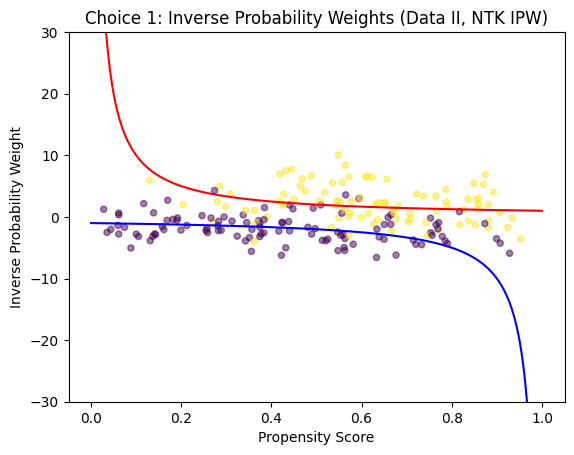

In [7]:
X_grad = X_brightness[grad_idx]
P_0 = propensity_score(X_grad[sidx])
W_0 = W_grad[sidx]


x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_ntk, c = W_0,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data II, NTK IPW)')
plt.ylim(-30, 30)
plt.show()

In [8]:

lambda1 =  6.944444444444444e-13
gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
ipw_estimate = np.mean(gamma_ntk * Yp)

print("IPW estimate:", ipw_estimate)

IPW estimate: 1.0705058168782584


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/4277997685.py:7: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/4277997685.py:8: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


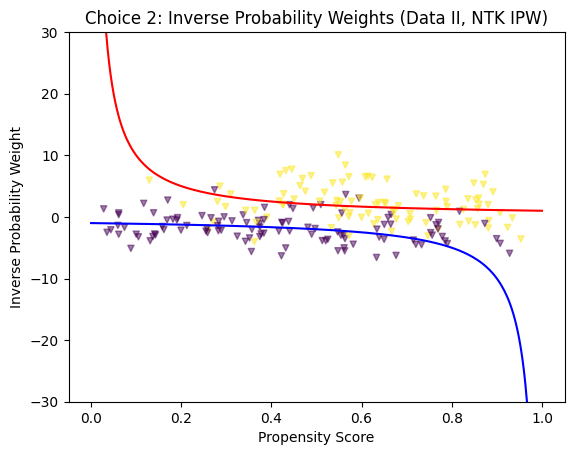

In [9]:
X_grad = X_brightness[grad_idx]
P_0 = propensity_score(X_grad[sidx])
W_0 = W_grad[sidx]


x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_ntk, c = W_0,alpha = .5, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data II, NTK IPW)')
plt.ylim(-30, 30)
plt.show()

AIPW

In [10]:
# AIPW

lambda1 = 3600
gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

y_predp = y_pred[sidx]
y_pred_controlp = y_pred_control[sidx]
y_pred_treatedp = y_pred_treated[sidx]
Yp = W_grad[sidx] * Y1_grad[sidx] + (1 - W_grad[sidx]) * Y0_grad[sidx]
AIPW_estimate = np.mean(y_pred_treatedp-y_pred_controlp)+np.mean(gamma_ntk * (Yp - y_predp))

print("IPW estimate:", AIPW_estimate)

IPW estimate: 1.0027586134044333


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/2342635316.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/2342635316.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


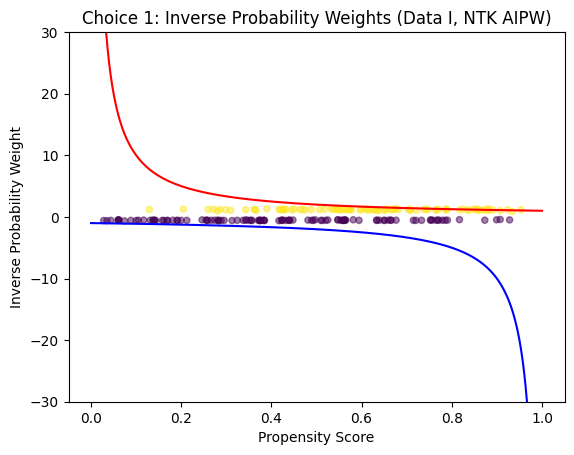

In [11]:
x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_ntk, c = W_0,alpha = .5, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 1: Inverse Probability Weights (Data I, NTK AIPW)')
plt.ylim(-30, 30)
plt.show()

In [12]:
# AIPW

lambda1 = 3000
gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

y_predp = y_pred[sidx]
y_pred_controlp = y_pred_control[sidx]
y_pred_treatedp = y_pred_treated[sidx]
Yp = W_grad[sidx] * Y1_grad[sidx] + (1 - W_grad[sidx]) * Y0_grad[sidx]
AIPW_estimate = np.mean(y_pred_treatedp-y_pred_controlp)+np.mean(gamma_ntk * (Yp - y_predp))

print("IPW estimate:", AIPW_estimate)

IPW estimate: 1.034899630512526


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/3631476324.py:2: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_737/3631476324.py:3: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


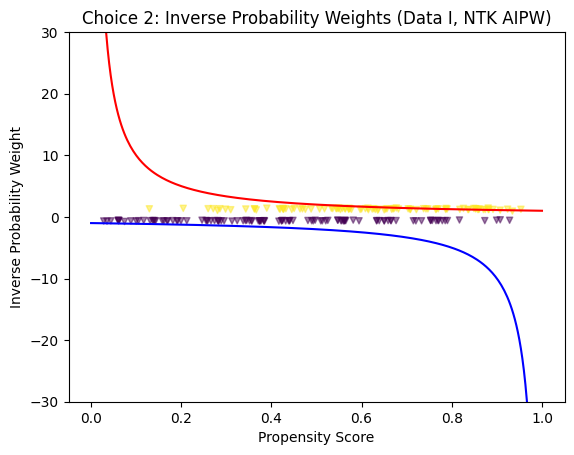

In [13]:
x_vals = np.linspace(1,0, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, gamma_ntk, c = W_0,alpha = .5, s = 20, marker='v')
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Choice 2: Inverse Probability Weights (Data I, NTK AIPW)')
plt.ylim(-30, 30)
plt.show()

Sampling Distribution

Mean IPW estimate: 1.05252799802999
Std. dev of IPW estimates: 0.022349164889510494
True arm coverage: 0.32


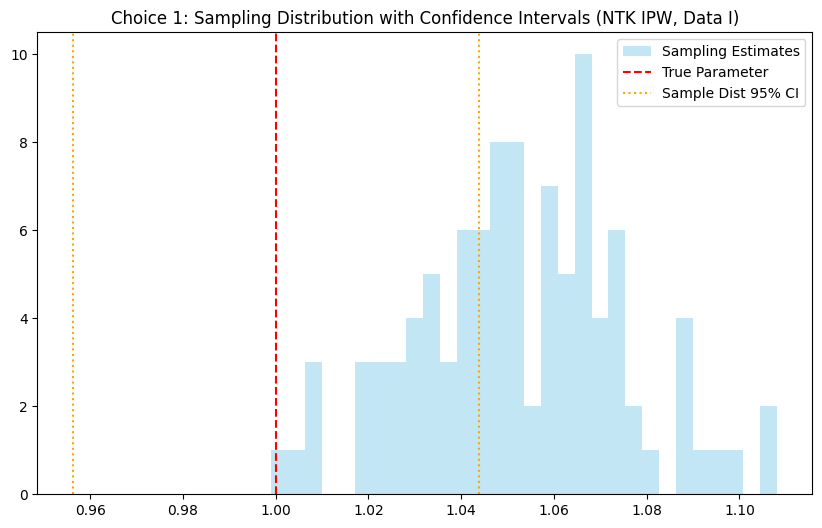

In [14]:
ipw_estimates = []
lambda1 = 2.5e-5
n_s = 200

for seed in range(0, 100):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_grad), n_s, replace=False)

    # Sample gradients and variables
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W_grad[sidx]
    Y1p = Y1_grad[sidx]
    Y0p = Y0_grad[sidx]

    def K_sampled(i, j):
        if W_sampled[i] == 0 and W_sampled[j] == 0:
            return f0_sampled_grads[i] @ f0_sampled_grads[j].T
        elif W_sampled[i] == 1 and W_sampled[j] == 1:
            return f1_sampled_grads[i] @ f1_sampled_grads[j].T
        else:
            return 0

    def K_diff_f(i, j, W_val):
        if W_sampled[i] == W_val:
            grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
            grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
            return grad_i @ grad_j.T
        return 0

    K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
    K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
    K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
    K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)

    gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

    Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
    ipw_estimate = np.mean(gamma_ntk * Yp)
    ipw_estimates.append(ipw_estimate)
    

# Convert to NumPy array for analysis
ipw_estimates = np.array(ipw_estimates)
sample_std = np.std(ipw_estimates)
true_arm_l, true_arm_r =  1- 1.96*sample_std, 1+1.96*sample_std
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage = np.mean(coverage_flags_ipw)


# Basic summary
print("Mean IPW estimate:", np.mean(ipw_estimates))
print("Std. dev of IPW estimates:", sample_std)
print("True arm coverage:", coverage)

plt.figure(figsize=(10, 6))
plt.hist(ipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')
plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (NTK IPW, Data I)')

plt.legend()
plt.show()

Mean IPW estimate: 1.0524298636146971
Std. dev of IPW estimates: 0.022471736985939975
True arm coverage: 0.32


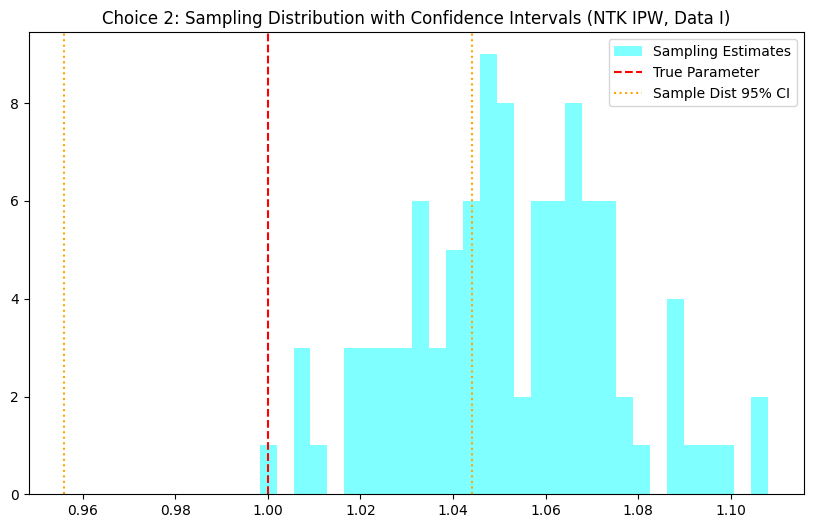

In [15]:
ipw_estimates = []
lambda1 = 6.944444444444444e-13
n_s = 200

for seed in range(0, 100):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_grad), n_s, replace=False)

    # Sample gradients and variables
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W_grad[sidx]
    Y1p = Y1_grad[sidx]
    Y0p = Y0_grad[sidx]

    def K_sampled(i, j):
        if W_sampled[i] == 0 and W_sampled[j] == 0:
            return f0_sampled_grads[i] @ f0_sampled_grads[j].T
        elif W_sampled[i] == 1 and W_sampled[j] == 1:
            return f1_sampled_grads[i] @ f1_sampled_grads[j].T
        else:
            return 0

    def K_diff_f(i, j, W_val):
        if W_sampled[i] == W_val:
            grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
            grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
            return grad_i @ grad_j.T
        return 0

    K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
    K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
    K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
    K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)

    gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

    Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
    ipw_estimate = np.mean(gamma_ntk * Yp)
    ipw_estimates.append(ipw_estimate)
    

# Convert to NumPy array for analysis
ipw_estimates = np.array(ipw_estimates)
sample_std = np.std(ipw_estimates)
true_arm_l, true_arm_r =  1- 1.96*sample_std, 1+1.96*sample_std
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in ipw_estimates]
coverage = np.mean(coverage_flags_ipw)


# Basic summary
print("Mean IPW estimate:", np.mean(ipw_estimates))
print("Std. dev of IPW estimates:", sample_std)
print("True arm coverage:", coverage)

plt.figure(figsize=(10, 6))
plt.hist(ipw_estimates, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')
plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (NTK IPW, Data I)')

plt.legend()
plt.show()

Sampling Distribution AIPW

Mean IPW estimate: 0.9998043980631885
Std. dev of IPW estimates: 0.02158273746648276
True arm coverage: 0.93


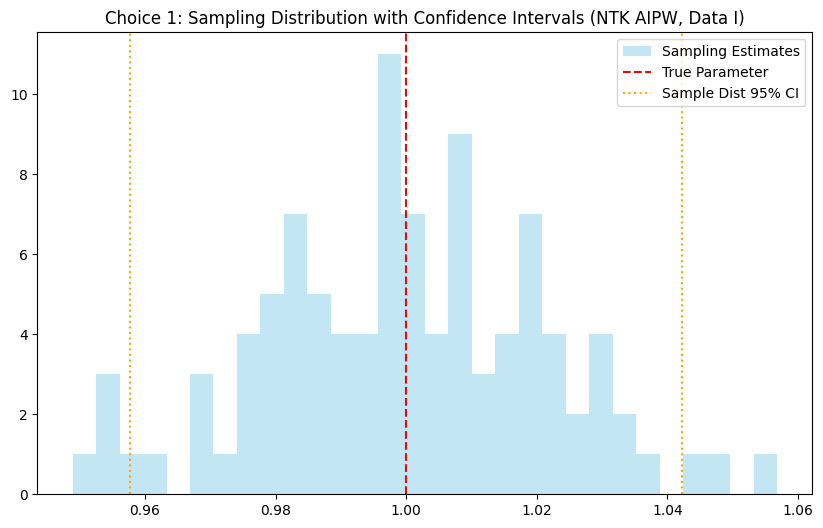

In [16]:
aipw_estimates = []
lambda1 = 3600
n_s = 200

for seed in range(0, 100):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_grad), n_s, replace=False)

    # Sample gradients and variables
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W_grad[sidx]
    Y1p = Y1_grad[sidx]
    Y0p = Y0_grad[sidx]

    def K_sampled(i, j):
        if W_sampled[i] == 0 and W_sampled[j] == 0:
            return f0_sampled_grads[i] @ f0_sampled_grads[j].T
        elif W_sampled[i] == 1 and W_sampled[j] == 1:
            return f1_sampled_grads[i] @ f1_sampled_grads[j].T
        else:
            return 0

    def K_diff_f(i, j, W_val):
        if W_sampled[i] == W_val:
            grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
            grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
            return grad_i @ grad_j.T
        return 0

    K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
    K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
    K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
    K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)

    gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

    Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
    aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_ntk * (Yp - y_pred[sidx]))
    aipw_estimates.append(aipw_estimate)
    

# Convert to NumPy array for analysis
aipw_estimates = np.array(aipw_estimates)
sample_std = np.std(aipw_estimates)
true_arm_l, true_arm_r =  1- 1.96*sample_std, 1+1.96*sample_std
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
coverage = np.mean(coverage_flags_ipw)


# Basic summary
print("Mean IPW estimate:", np.mean(aipw_estimates))
print("Std. dev of IPW estimates:", sample_std)
print("True arm coverage:", coverage)

plt.figure(figsize=(10, 6))
plt.hist(aipw_estimates, bins=30, alpha=0.5, color='skyblue', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')
plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 1: Sampling Distribution with Confidence Intervals (NTK AIPW, Data I)')

plt.legend()
plt.show()

Mean IPW estimate: 1.0307524875640082
Std. dev of IPW estimates: 0.0229556054738657
True arm coverage: 0.73


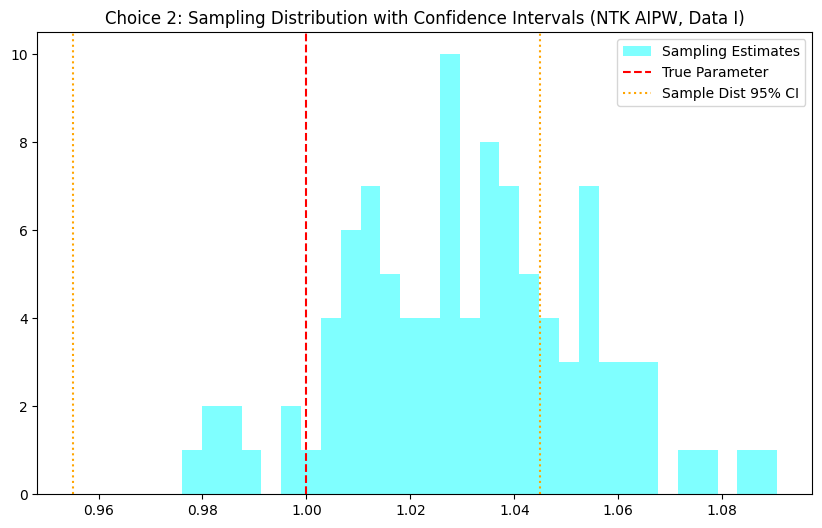

In [17]:
aipw_estimates = []
lambda1 = 3000
n_s = 200

for seed in range(0, 100):
    np.random.seed(seed)
    sidx = np.random.choice(len(X_grad), n_s, replace=False)

    # Sample gradients and variables
    f0_sampled_grads = [f0_grads[i] for i in sidx]
    f1_sampled_grads = [f1_grads[i] for i in sidx]
    W_sampled = W_grad[sidx]
    Y1p = Y1_grad[sidx]
    Y0p = Y0_grad[sidx]

    def K_sampled(i, j):
        if W_sampled[i] == 0 and W_sampled[j] == 0:
            return f0_sampled_grads[i] @ f0_sampled_grads[j].T
        elif W_sampled[i] == 1 and W_sampled[j] == 1:
            return f1_sampled_grads[i] @ f1_sampled_grads[j].T
        else:
            return 0

    def K_diff_f(i, j, W_val):
        if W_sampled[i] == W_val:
            grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
            grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
            return grad_i @ grad_j.T
        return 0

    K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
    K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
    K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
    K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)

    gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)

    Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
    aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_ntk * (Yp - y_pred[sidx]))
    aipw_estimates.append(aipw_estimate)
    

# Convert to NumPy array for analysis
aipw_estimates = np.array(aipw_estimates)
sample_std = np.std(aipw_estimates)
true_arm_l, true_arm_r =  1- 1.96*sample_std, 1+1.96*sample_std
coverage_flags_ipw = [(true_arm_l <= pe <= true_arm_r) for pe in aipw_estimates]
coverage = np.mean(coverage_flags_ipw)


# Basic summary
print("Mean IPW estimate:", np.mean(aipw_estimates))
print("Std. dev of IPW estimates:", sample_std)
print("True arm coverage:", coverage)

plt.figure(figsize=(10, 6))
plt.hist(aipw_estimates, bins=30, alpha=0.5, color='cyan', label='Sampling Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')
plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Choice 2: Sampling Distribution with Confidence Intervals (NTK AIPW, Data I)')

plt.legend()
plt.show()

k selection IPW

In [30]:
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]
ps = 6000
sigma = 1
n_s = 200
true_ate = 1  # replace this with your true ATE

rmses = []
biasv = []
Bsv = []
coveragev = []

for k in k_values:
    Bs = ps ** k
    Bsv.append(Bs)
    lambda1 = sigma**2 / (Bs**2 * n_s**2)

    ipw_estimates = []

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(len(X_grad), n_s, replace=False)

        # Sample gradients and variables
        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W_grad[sidx]
        Y1p = Y1_grad[sidx]
        Y0p = Y0_grad[sidx]

        def K_sampled(i, j):
            if W_sampled[i] == 0 and W_sampled[j] == 0:
                return f0_sampled_grads[i] @ f0_sampled_grads[j].T
            elif W_sampled[i] == 1 and W_sampled[j] == 1:
                return f1_sampled_grads[i] @ f1_sampled_grads[j].T
            else:
                return 0

        def K_diff_f(i, j, W_val):
            if W_sampled[i] == W_val:
                grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
                grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
                return grad_i @ grad_j.T
            return 0

        K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
        K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
        K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
        K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)

        gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)
        Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
        ipw_estimate = np.mean(gamma_ntk * Yp)
        ipw_estimates.append(ipw_estimate)

    ipw_estimates = np.array(ipw_estimates)
    sample_mean = np.mean(ipw_estimates)
    sample_std = np.std(ipw_estimates)
    rmse = np.sqrt(np.mean((ipw_estimates - true_ate)**2))
    bias = np.abs(sample_mean - true_ate)

    # Coverage calculation
    true_arm_l, true_arm_r = true_ate - 1.96 * sample_std, true_ate + 1.96 * sample_std
    coverage_flags = [(true_arm_l <= est <= true_arm_r) for est in ipw_estimates]
    coverage = np.mean(coverage_flags)

    # Store
    rmses.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)

    print(f"k = {k:.2f}, Bs = {Bs:.2f}, lambda = {lambda1}, RMSE = {rmse:.4f}, Bias = {bias:.4f}, Coverage = {coverage:.2f}")



k = -1.00, Bs = 0.00, lambda = 900.0, RMSE = 0.1117, Bias = 0.1062, Coverage = 0.14
k = -0.75, Bs = 0.00, lambda = 11.618950038622252, RMSE = 0.1496, Bias = 0.1475, Coverage = 0.00
k = -0.50, Bs = 0.01, lambda = 0.15000000000000002, RMSE = 0.0919, Bias = 0.0900, Coverage = 0.00
k = -0.25, Bs = 0.11, lambda = 0.0019364916731037087, RMSE = 0.0606, Bias = 0.0575, Coverage = 0.12
k = 0.00, Bs = 1.00, lambda = 2.5e-05, RMSE = 0.0571, Bias = 0.0525, Coverage = 0.32
k = 0.25, Bs = 8.80, lambda = 3.227486121839514e-07, RMSE = 0.0570, Bias = 0.0524, Coverage = 0.32
k = 0.50, Bs = 77.46, lambda = 4.166666666666667e-09, RMSE = 0.0570, Bias = 0.0524, Coverage = 0.32
k = 0.75, Bs = 681.73, lambda = 5.37914353639919e-11, RMSE = 0.0570, Bias = 0.0524, Coverage = 0.32
k = 1.00, Bs = 6000.00, lambda = 6.944444444444444e-13, RMSE = 0.0570, Bias = 0.0524, Coverage = 0.32


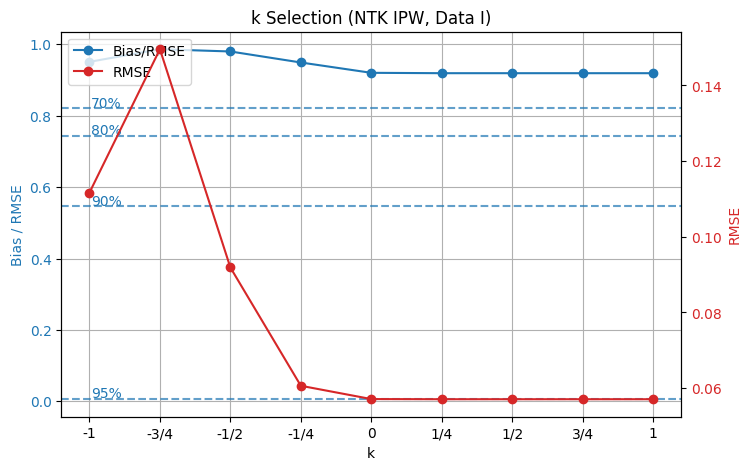

In [31]:
coverage_levels = {
    "95%": 0.00606,
    "90%": 0.54640,
    "80%": 0.74434,
    "70%": 0.82037
}

biasoverrmse = np.array(biasv)/np.array(rmses)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2', '3/4', '1'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmses, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Title, grid, and layout
plt.title('k Selection (NTK IPW, Data I)')
ax1.grid(True)
plt.show()


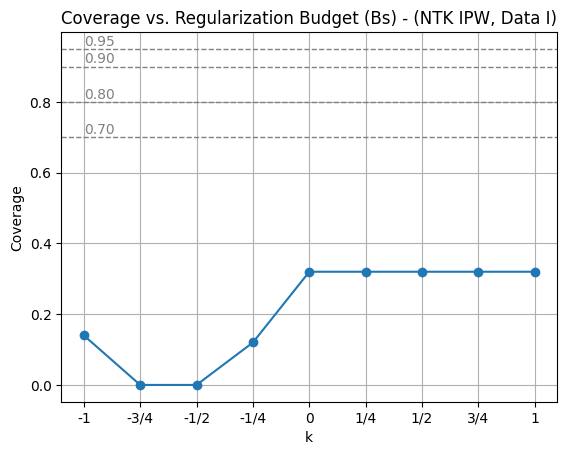

In [32]:
#coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK IPW, Data I)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2', '3/4', '1'])
plt.show()

K selection AIPW

In [33]:
k_values = [-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1]
ps = 6000
sigma = 2
n_s = 200
true_ate = 1  # replace this with your true ATE

rmses = []
biasv = []
Bsv = []
coveragev = []

for k in k_values:
    Bs = ps ** k
    Bsv.append(Bs)
    lambda1 = sigma**2 / (Bs**2 * n_s**2)

    aipw_estimates = []

    for seed in range(100):
        np.random.seed(seed)
        sidx = np.random.choice(len(X_grad), n_s, replace=False)

        # Sample gradients and variables
        f0_sampled_grads = [f0_grads[i] for i in sidx]
        f1_sampled_grads = [f1_grads[i] for i in sidx]
        W_sampled = W_grad[sidx]
        Y1p = Y1_grad[sidx]
        Y0p = Y0_grad[sidx]

        def K_sampled(i, j):
            if W_sampled[i] == 0 and W_sampled[j] == 0:
                return f0_sampled_grads[i] @ f0_sampled_grads[j].T
            elif W_sampled[i] == 1 and W_sampled[j] == 1:
                return f1_sampled_grads[i] @ f1_sampled_grads[j].T
            else:
                return 0

        def K_diff_f(i, j, W_val):
            if W_sampled[i] == W_val:
                grad_i = f1_sampled_grads[i] if W_val == 1 else f0_sampled_grads[i]
                grad_j = f1_sampled_grads[j] if W_val == 1 else f0_sampled_grads[j]
                return grad_i @ grad_j.T
            return 0

        K_XX = np.array([[K_sampled(i, j) for j in range(n_s)] for i in range(n_s)])
        K_TT = np.array([[K_diff_f(i, j, 1) for j in range(n_s)] for i in range(n_s)])
        K_CC = np.array([[K_diff_f(i, j, 0) for j in range(n_s)] for i in range(n_s)])
        K_diff = np.sum(K_TT, axis=1) - np.sum(K_CC, axis=1)

        gamma_ntk = np.linalg.solve(K_XX + lambda1 * np.eye(n_s), K_diff)
        Yp = W_sampled * Y1p + (1 - W_sampled) * Y0p
        aipw_estimate = np.mean(y_pred_treated[sidx] - y_pred_control[sidx]) + np.mean(gamma_ntk * (Yp - y_pred[sidx]))
        aipw_estimates.append(aipw_estimate)

    aipw_estimates = np.array(aipw_estimates)
    sample_mean = np.mean(aipw_estimates)
    sample_std = np.std(aipw_estimates)
    rmse = np.sqrt(np.mean((aipw_estimates - true_ate)**2))
    bias = np.abs(sample_mean - true_ate)

    # Coverage calculation
    true_arm_l, true_arm_r = true_ate - 1.96 * sample_std, true_ate + 1.96 * sample_std
    coverage_flags = [(true_arm_l <= est <= true_arm_r) for est in aipw_estimates]
    coverage = np.mean(coverage_flags)

    # Store
    rmses.append(rmse)
    biasv.append(bias)
    coveragev.append(coverage)

    print(f"k = {k:.2f}, Bs = {Bs:.2f}, lambda = {lambda1}, RMSE = {rmse:.4f}, Bias = {bias:.4f}, Coverage = {coverage:.2f}")



k = -1.00, Bs = 0.00, lambda = 3600.0, RMSE = 0.0216, Bias = 0.0002, Coverage = 0.93
k = -0.75, Bs = 0.00, lambda = 46.47580015448901, RMSE = 0.4839, Bias = 0.4828, Coverage = 0.00
k = -0.50, Bs = 0.01, lambda = 0.6000000000000001, RMSE = 0.5777, Bias = 0.5771, Coverage = 0.00
k = -0.25, Bs = 0.11, lambda = 0.007745966692414835, RMSE = 0.6230, Bias = 0.6225, Coverage = 0.00
k = 0.00, Bs = 1.00, lambda = 0.0001, RMSE = 0.6344, Bias = 0.6337, Coverage = 0.00
k = 0.25, Bs = 8.80, lambda = 1.2909944487358056e-06, RMSE = 0.6347, Bias = 0.6341, Coverage = 0.00
k = 0.50, Bs = 77.46, lambda = 1.6666666666666667e-08, RMSE = 0.6348, Bias = 0.6341, Coverage = 0.00
k = 0.75, Bs = 681.73, lambda = 2.151657414559676e-10, RMSE = 0.6348, Bias = 0.6341, Coverage = 0.00
k = 1.00, Bs = 6000.00, lambda = 2.7777777777777777e-12, RMSE = 0.6348, Bias = 0.6341, Coverage = 0.00


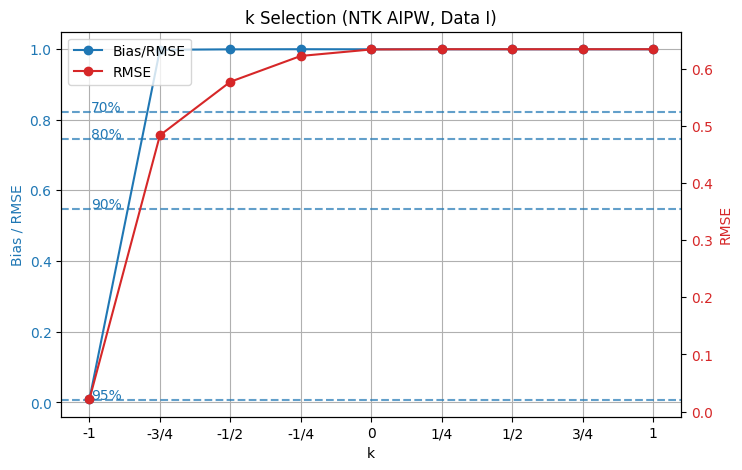

In [34]:
biasoverrmse = np.array(biasv)/np.array(rmses)  

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Bias / RMSE
color1 = 'tab:blue'
line1, = ax1.plot(np.log(Bsv), biasoverrmse, marker='o', color=color1, label='Bias/RMSE')
ax1.set_xlabel('k')
ax1.set_ylabel('Bias / RMSE', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X-axis ticks
ax1.set_xticks(np.log(Bsv))
ax1.set_xticklabels(['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2', '3/4', '1'])

# Add horizontal lines for coverage levels
for label, threshold in coverage_levels.items():
    ax1.axhline(y=threshold, color=color1, linestyle='--', alpha=0.7)
    ax1.text(np.log(Bsv[0]) + 0.05, threshold+0.015, label,
             va='center', ha='left', fontsize=10, color=color1)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(np.log(Bsv), rmses, marker='o', color=color2, label='RMSE')
ax2.set_ylabel('RMSE', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')


# Title, grid, and layout
plt.title('k Selection (NTK AIPW, Data I)')
ax1.grid(True)
plt.show()


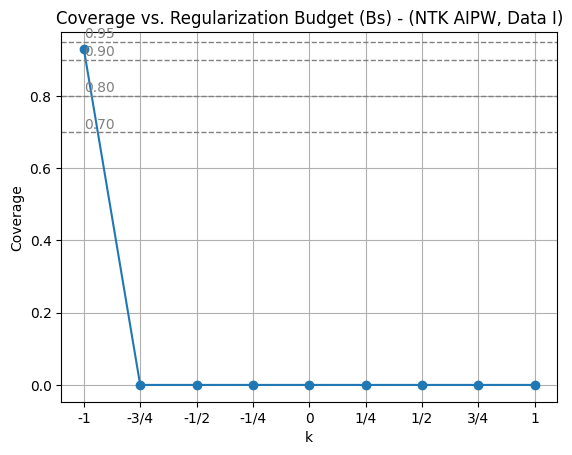

In [35]:
#coverage
plt.plot(np.log(Bsv), coveragev, marker='o', label='Coverage')
# Add horizontal reference lines at common confidence levels
for level in [0.7, 0.8, 0.9, 0.95]:
    plt.axhline(y=level, color='gray', linestyle='--', linewidth=1)
    plt.text(np.log(Bsv)[0], level + 0.01, f'{level:.2f}', color='gray')
# Customize the plot
plt.xlabel('k')
plt.ylabel('Coverage')
plt.title('Coverage vs. Regularization Budget (Bs) - (NTK AIPW, Data I)')
plt.grid(True)
plt.xticks(np.log(Bsv), ['-1', '-3/4', '-1/2', '-1/4', '0', '1/4', '1/2', '3/4', '1'])
plt.show()